<a href="https://colab.research.google.com/github/niranjana2222/Neural-Networks-and-ODE-Models/blob/main/Dirichlet_Boundary_Condition_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

## check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

#boundary conditions
A = 0.
B = 0.

#trial solution
Psi_t = lambda x: A*(1-x) + B * x + (1-x)* x * N(x)

f = lambda x, Psi: -1

#loss function
def loss(x):

    x.requires_grad = True
    outputs = Psi_t(x)

    #we need Psi_x_x 
    #calculating gradient twice 

    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                            create_graph=True)[0]
    Psi_t_x_x = torch.autograd.grad(Psi_t_x, x, grad_outputs=torch.ones_like(Psi_t_x),
                                            create_graph=True )[0]

    return torch.mean((Psi_t_x_x - f(x, outputs)) ** 2)

#recommended optimizer
optimizer = torch.optim.LBFGS(N.parameters())
x = torch.Tensor(np.linspace(0, 1, 100)[:, None])


In [7]:
#run optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l

for i in range(10):
    optimizer.step(closure)

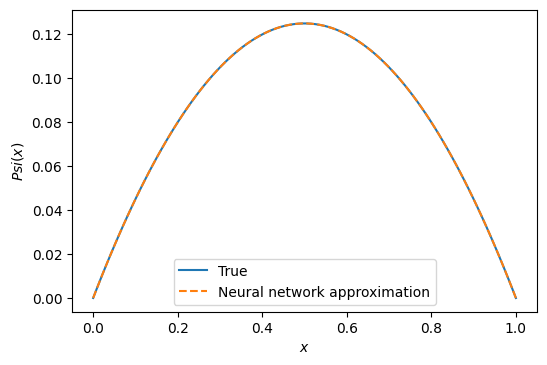

In [8]:
#compare nn to analytical solution
xx = np.linspace(0, 1, 100)[:, None]

with torch.no_grad():
    yy = Psi_t(torch.Tensor(xx)).numpy()

yt = (0.5) * (-xx**2 + xx ) #actual function pts

fig, ax = plt.subplots(dpi=100)
ax.plot(xx, yt, label='True')
ax.plot(xx, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$Psi(x)$')
plt.legend(loc='best');